In [ ]:
import os, sys
# sys.path.append('c:\conda_scripts')
import gsflow
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
# import SRPHM
import geopandas as gpd
import pickle
import pandas as pd
# import arich_functions
# from load_cwdm import load_cwdm_input
# import setup_srphm
# import make_map as mp
# import plot_help as ph
# import plot_wet as pw
import cartopy.crs as ccrs 
import flopy.utils.binaryfile as bf
import contextily as ctx
import fiona
import seaborn as sns
# import gwplot_wiski
# import arich_functions as af

In [ ]:
import conda_scripts

In [ ]:
from conda_scripts.sv_budget import sv_budget
from conda_scripts.sv_budget import sv_farm_bud
from conda_scripts.sv_budget import sv_modflow
# from conda_scripts.sv_budget import hydrology

In [ ]:
owhm2 = r"C:\GSP\sv\model\SV_mod_V2_owhm2\master"

In [ ]:
# workspace = r'C:\GSP\sv\budget\SV_WB_revA\SV_WB_revA\SVIGFM_output\SVIGFM_revA_outputfiles'
# workspace = r'C:\GSP\sv\budget\results'
workspace = r"C:\GSP\sv\model\SV_mod_V2\master"
cbc = r'sv_model_grid_6layers.cbb'
zones_ = r"C:\GSP\sv\budget\SV_WB_revA\SV_WB_revA\Zones\SonomaZoneUpdate.zon"

out_fold = r'SV_bud_output'

sfr_out = r"sv_model_grid_6layers_gage_str.dat"

GIS_out = os.path.join('C:\GSP\sv','GIS')
gdb = os.path.join(GIS_out,'sv_model_geodatabase.gdb')
print(f'these are the files in the main gdb\n{(fiona.listlayers(gdb))}')

svzones_gis_path = os.path.join(GIS_out, 'SV_zones.shp')
zones_gis = gpd.read_file(svzones_gis_path)
zones_gis = zones_gis[zones_gis.ZoneUpdate==1]
sfr_inflow_path = os.path.join(GIS_out,'sfr_inflowoutflow.shp')

SFR_basin  = gpd.read_file(r'c:\GSP\sv\GIS\SFR_basin.shp')

sfr_loc = 'SFR_all_cells'
sfr_cells = gpd.read_file(gdb,layer =sfr_loc)

active_grid = gpd.read_file(gdb,layer = 'active_grid_cells')
active_grid_dis = gpd.read_file(gdb,layer = 'active_grid_cells_dissolve')
active_grid_dis.insert(0,'Sub','Sub')
active_grid_dis = active_grid_dis.dissolve("Sub")
sv_wtrshed = gpd.read_file(gdb,layer = 'SonValleyWtrShd')
subcat = gpd.read_file(gdb,layer = 'SCWA_sonoma_valley_BCM_subcatchments')
farms = gpd.read_file(gdb,layer = 'FMP_Cells_2014_2016')
farms_base = gpd.read_file(gdb,layer = 'FMP_farm_number_base')
faults = gpd.read_file(gdb,layer = 'Faults_HFB')

# load inflow points
inflow = gpd.read_file(sfr_inflow_path).rename(columns = {'Segment':'segment', 'Reach':'reach'})

# mtn front runoff connections
# mtn_front_connex_path = r"T:\arich\Sonoma_Valley\hydro_stat\mtn_front_recharge\mtn_front_runoff\RUNOFF_SCWA_sonoma_valley_BCM_subcatchments_with_sfr_segs.shp"

mtn_front_connex = gpd.read_file(gdb,layer = 'RUNOFF_SCWA_sonoma_valley_BCM_subcatchments_with_sfr_segs')

# mtn_front_connex = gpd.read_file(mtn_front_connex_path)

swdivs_path = os.path.join(GIS_out,r"surface water divs\surface water divs\PODS_active_model.shp")
swdivs = gpd.read_file(swdivs_path)
swdivs_basin = swdivs.within(active_grid_dis)

bas = gpd.read_file(gdb, layer='Bulletin_118_Gwbasin_reproj')

bas = bas.query("Basin_Name.str.startswith('NAPA')").loc[:,['Basin_Name','geometry']]

In [ ]:
conda_scripts.load_datasets.model_info.get_mod(basin = 'Son', historical = True)

In [ ]:
dts = conda_scripts.utils.get_dates.get_dates()
ml = conda_scripts.sv_budget.load_sv_model.get_model()

In [ ]:
sr, mg, modgeoms = conda_scripts.arich_functions.get_flopy_model_spatial_reference('sv', True)

In [ ]:
grid_sub = gpd.sjoin(modgeoms, subcat, how = 'left')
grid_sub = grid_sub.query("GRIDCODE>0").drop_duplicates(['i','j'])

In [ ]:
grid_sub.GRIDCODE.nunique()

In [ ]:
mtn_front_connex.loc[:,'FARM'] = mtn_front_connex.index+81

In [ ]:
mtn_front_connex.head()

In [ ]:
mtn_front_connex.loc[:,['FARM','FARM', 'flow']].astype({"flow":int}).to_clipboard(index = False)

# filter cells active in model already

In [ ]:
ibnd = ml.bas6.ibound.array[0]

i,j = np.indices(ibnd.shape)

ind = np.hstack((ibnd.reshape((-1,1)), i.reshape((-1,1)), j.reshape((-1,1))))

ind = ind[ind[:,0]==0,:]

# Example lists of points
points = grid_sub.loc[:,['i','j']].values
filter_points =  [tuple(row) for row in ind[:,1:].tolist()]

# [x if x % 2 == 0 else -x for x in y]
# Filtering points
filtered_points = [tuple(item) in filter_points for item in points]

# grid_sub = grid_sub.loc[grid_sub.loc[:,'i'].isin(pd.Series(ind[:,1])) & grid_sub.loc[:,'j'].isin(pd.Series(ind[:,2]))]
grid_sub =  grid_sub.loc[filtered_points]
m = grid_sub.explore()
active_grid.explore(m = m, color = 'r')

In [ ]:
os.getcwd()

In [ ]:
fig = plt.figure(figsize = (8.5,11), dpi = 250)
mm = conda_scripts.make_map.make_map("Extending Model Area")

ax = mm.plotloc(fig, locname = 'Son_mod')


subcat.plot(hatch = '/////', ax = ax, facecolor = "None", zorder = 5)
ax = grid_sub.plot('GRIDCODE', ax= ax, zorder =6,)
subcat.plot(ax = ax,facecolor = "None", zorder = 100)
active_grid_dis.plot(ax = ax, facecolor = "None", edgecolor = 'r', zorder = 101)
plt.savefig('subcat_extend.png')

In [ ]:
grid_sub

In [ ]:
grid_sub.to_file(gdb, layer = 'subcat_farms')

In [ ]:
grid_sub.query("GRIDCODE>0").dissolve("GRIDCODE").reset_index().explore("GRIDCODE", categorical = True)

In [ ]:
active_sub = conda_scripts.arich_functions.rw2aray(ml.dis.nrow, ml.dis.ncol, grid_sub.row, grid_sub.col, grid_sub.GRIDCODE, 'active')['active']

In [ ]:
mtn_front_connex.head()

In [ ]:
pd.Series(active_sub.ravel()).value_counts()

In [ ]:
for _,row in mtn_front_connex.iterrows():
    c = active_sub == row['GRIDCODE']
    active_sub[c] = row['FARM']

In [ ]:
t = np.copy(ml.bas6.ibound.array[0])

t[active_sub>0] = t[active_sub>0]+1

plt.imshow(t)

In [ ]:
plt.imshow(active_sub[:,:])

In [ ]:
modgeoms.plot()

In [ ]:
sr, mg,geom = conda_scripts.arich_functions.get_flopy_model_spatial_reference('sv',True)
# zb_df, ml, divs = conda_scripts.sv_budget.sv_modflow.get_zone_bud(workspace, zones_,cbc,sfr_cells, sfr_path =  "sv_GSP.sfr", read_pickle=True )

In [ ]:
fmp = r"C:\GSP\sv\model\SV_mod_V2\master\sv_model_FMP_GSP.fmp"
top = []
mnw = []
farms = []
irr_eff =[]
crops = []
kc = []
pet = []
ftr = []
precip = []
nrd = []
with open(fmp,'r') as fm:
    for _ in range(63):
        line = fm.readline()
#     for row in fm.readlines():
#         print(row)
#     line = fm.readline()
    while line:
        
        line = fm.readline()

        top.append(line)
        mnw.append(fm.readline())
        farms.append(fm.readline())
        irr_eff.append(fm.readline())
        crops.append(fm.readline())
        kc.append(fm.readline())
        pet.append(fm.readline())
        ftr.append(fm.readline())
        precip.append(fm.readline())
        nrd.append(fm.readline())
        
    out = dict(top=top,
            mnw=mnw,
            farms=farms,
            irr_eff=irr_eff,
            crops= crops,
            kc=kc,
            pet=pet,
            ftr=ftr,
            precip=precip,
            nrd=nrd)

In [ ]:
out

In [ ]:
grid = conda_scripts.arich_functions.get_active_mod_df(mg, ml)

In [ ]:

def array2df(array,name):
    df = conda_scripts.arich_functions.array2rc(array,name = name)
    return df

def load_arrays(listname,dtype= int):
    print(f'loading list from {listname[0:5]}')
    allfarms = None
    for cnt, k in enumerate(listname):
        if len(k)==0:
            break
        file = k.split()[1]
        fl = os.path.join(workspace,file )

        if ',' in open(fl, 'r').readline():
            d = ','
        else:
            d = None
        array = np.genfromtxt(fl, dtype = dtype,delimiter = d)
        df = array2df(array, dts.loc[cnt,'date'].strftime('%Y-%b'))

        if type(allfarms) == type(None):
            allfarms = df
        else:
            allfarms = allfarms.join(df.loc[:,[dts.loc[cnt,'date'].strftime('%Y-%b')]])

    allfarms = pd.merge(grid,allfarms.drop(columns = ['row','column']),left_on =['i','j'],right_on = ['i','j'] )
    allfarms = gpd.GeoDataFrame(allfarms, geometry = 'geometry', crs =2226)
    return allfarms
    
# allfarms = load_arrays(farms)
allcrops = load_arrays(crops)

allpet = load_arrays(pet, dtype =float)
allprecip = load_arrays(precip, dtype =float)

# add elevation to predictions

In [ ]:
elev = modgeoms.copy()
elev = elev.set_geometry(elev.geometry.centroid)
elev.loc[:,'z'] = conda_scripts.utils.elevation.calc_elev(elev)

elev = elev.loc[:,['i','j','z']]

# predict the mountain front recharge areas for precip and pet

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def pred(df, elev):

    p = df.set_index(['i', 'j']).iloc[:,4:]
    p = p.rename(columns = pd.to_datetime)
    p = p.stack().to_frame('Q').reset_index()
    p.loc[:,'date'] = p.loc[:,'level_2'].astype('int64')
    p = pd.merge(p, elev, on = ['i','j'])
    
    pred_locs = grid_sub.query("GRIDCODE>0").drop_duplicates(['i','j']).loc[:,['i','j']]
    pred_locs.loc[:,'n'] = 1

    dum = p.drop_duplicates('date').loc[:,['date']]
    dum.loc[:,'n'] = 1

    pred_locs = pd.merge(pred_locs, dum, on = 'n')
    
    pred_locs = pd.merge(pred_locs, elev, on = ['i','j'])
    cols = ['i', 'j', 'z','date']

    print('training model')
    # Train the model
    model = RandomForestRegressor(n_estimators=10, random_state=42)
    model.fit(p.loc[:,cols], p.loc[:,'Q'])
    print('predicting')
    # Evaluate the model
    y_pred = model.predict(pred_locs.loc[:,cols])

    pred_locs.loc[:,'Q'] = y_pred

    all_out = pd.concat([p, pred_locs])

    return p, pred_locs, all_out

# d, pred_locs, predicted= pred(allprecip, elev)
d, pred_locs, predicted= pred(allpet, elev)

In [ ]:
def export_pred(prdf, fmt = "%.9g", folder = 'finf', prepend_text = ''):
    c = prdf.drop(columns = ['level_2','n','z']).drop_duplicates([ 'i', 'j','date',]).set_index([ 'i', 'j','date',]).unstack().droplevel(0,1).reset_index()
    c = c.set_index([ 'i', 'j']).rename(columns = pd.to_datetime)


    path = os.path.join(owhm2, 'fmp_input', folder)
    
    for column in c.columns:
        date = column.strftime("%Y%b").lower()
        file = os.path.join(path, "{}{}.txt".format(prepend_text, date))
        print(file, column)
        cdf = c.loc[:,[column]]
        # print(column)
        # print(cdf.head())
        # print(type(cdf))
        row = cdf.index.get_level_values(0).values+1
        col = cdf.index.get_level_values(1).values+1

        # print(row[0:5])
        # cdf.loc[:,column].values
        value = cdf.loc[:,column].values

        arr = conda_scripts.arich_functions.rw2aray(ml.dis.nrow, ml.dis.ncol, row = row, col = col, value = value, name =  'active')['active']
                    # conda_scripts.arich_functions.rw2aray(ml.dis.nrow, ml.dis.ncol, grid_sub.row, grid_sub.col, grid_sub.GRIDCODE, 'active')
        
        np.savetxt(file, arr, fmt = fmt, delimiter = ',')

    return arr

pp = export_pred(predicted, folder = 'pet', prepend_text = 'pet')
# pp = export_pred(predicted, folder = 'finf', prepend_text = 'finf')

# add crops to crops/farms

In [ ]:
clist = os.path.join(workspace, 'fmp_input', 'crops')
files = os.listdir(clist)

for f in files:

    file = os.path.join(clist,f)
    # crops = np.genfromtxt(os.path.join(clist,f))
    # file = k.split()[1]
    # fl = os.path.join(workspace,file )

    if ',' in open(file, 'r').readline():
        d = ','
    else:
        d = None
        
    crops = np.genfromtxt(file, dtype= int, delimiter = d)
    # print(crops.ravel().unique())
    crops[active_sub>0] = 6
    np.savetxt(os.path.join(owhm2, 'fmp_input','crops',f), crops,  fmt="%d",)



In [ ]:
plt.imshow(crops)

In [ ]:
clist = os.path.join(workspace, 'fmp_input', 'farms')
files = os.listdir(clist)

for f in files:

    file = os.path.join(clist,f)
    print(file)
    # crops = np.genfromtxt(os.path.join(clist,f))
    # file = k.split()[1]
    # fl = os.path.join(workspace,file )

    if ',' in open(file, 'r').readline():
        d = ','
    else:
        d = None
        
    crops = np.genfromtxt(file, dtype= int, delimiter = d)
    # print(crops.ravel().unique())
    crops[active_sub>0] =active_sub[active_sub>0]
    np.savetxt(os.path.join(owhm2, 'fmp_input','farms',f), crops,  fmt="%d",)

In [ ]:
plt.imshow(crops,cmap = 'jet')

In [ ]:
elev = conda_scripts.utils.elevation.calc_elev(geom.set_geometry(geom.geometry.centroid))

# set layer 2 ibound to subcatc

In [ ]:
plt.imshow(ml.bas6.ibound.array[0])

In [ ]:
fig, ax = plt.subplots(3,2)
ax = ax.ravel()
for lay in np.arange(ml.dis.nlay):
    arr = np.copy(ml.bas6.ibound.array[lay])
    if lay==1:
        arr[active_sub>0] = 1
        
    np.savetxt(os.path.join(owhm2, 'model_arrays',f'ibound_{lay+1}.txt'), arr,  fmt="%d",)

    ax[lay].imshow(arr)
    # ax = plt.imshow(arr)

    ax[lay].set_title(f'layer {lay}')
    # ax[lay].axes('off')

# set initial heads

In [ ]:
clist = os.path.join(workspace, 'init_heads')
files = os.listdir(clist)

fig, ax = plt.subplots(3,2)
ax = ax.ravel()
for lay,f in enumerate(files):
    print(f)
    file = os.path.join(clist,f)
    # crops = np.genfromtxt(os.path.join(clist,f))
    # file = k.split()[1]
    # fl = os.path.join(workspace,file )

    if ',' in open(file, 'r').readline():
        d = ','
    else:
        d = None
        
    crops = np.genfromtxt(file,  delimiter = d)
    # print(crops.ravel().unique())
    if lay ==1:
        crops[active_sub>0] = ml.dis.top[active_sub>0]

    out = os.path.join(owhm2, 'init_heads',f)
    print(out)
    np.savetxt(out, crops,  fmt="%.3g",)

    ax[lay].imshow(crops.T)
    # ax = plt.imshow(arr)

    ax[lay].set_title(f'layer {lay}')

# fix lay 2 (hk_3.csv) to not have null values


nothing actually done here

In [ ]:
clist = os.path.join(workspace, 'layer_percents_REDO')
files = os.listdir(clist)
print(files)
files = [xx for xx in files if 'Hk_' in xx]
print(files)
fig, ax = plt.subplots(3,2)
ax = ax.ravel()
for lay,f in enumerate(files):
    print(f)
    file = os.path.join(clist,f)
    # crops = np.genfromtxt(os.path.join(clist,f))
    # file = k.split()[1]
    # fl = os.path.join(workspace,file )

    if ',' in open(file, 'r').readline():
        d = ','
    else:
        d = None
        
    crops = np.genfromtxt(file,  delimiter = d)
    # print(crops.ravel().unique())
    # if lay ==1:
    #     crops[active_sub>0] = .5

    out = os.path.join(owhm2, 'layer_percents_REDO',f)
    
    print(out)
        
    np.savetxt(out, crops,  fmt="%.8g",)

    ax[lay].imshow(crops.T)
    # ax = plt.imshow(arr)

    ax[lay].set_title(f)

In [ ]:
clist = os.path.join(workspace, 'layer_percents_REDO')
files = os.listdir(clist)
print(files)
files = [xx for xx in files if 'Vk_' in xx]
print(files)
fig, ax = plt.subplots(3,2)
ax = ax.ravel()
for lay,f in enumerate(files):
    print(f)
    file = os.path.join(clist,f)
    # crops = np.genfromtxt(os.path.join(clist,f))
    # file = k.split()[1]
    # fl = os.path.join(workspace,file )

    if ',' in open(file, 'r').readline():
        d = ','
    else:
        d = None
        
    crops = np.genfromtxt(file,  delimiter = d)
    # print(crops.ravel().unique())
    # if lay ==1:
    #     crops[active_sub>0] = .5

    out = os.path.join(owhm2, 'layer_percents_REDO',f)
    
    print(out)
    np.savetxt(out, crops,  fmt="%.8g",)

    ax[lay].imshow(crops.T)
    # ax = plt.imshow(arr)

    ax[lay].set_title(f)

# fixing soil

In [ ]:
clist = os.path.join(owhm2, r'fmp_input', r'model_arrays')
files = os.listdir(clist)
print(owhm2)

In [ ]:
soil = "C:\GSP\sv\model\SV_mod_V2_owhm2\master\fmp_input\model_arrays\soils_redo_with_all_active_as_nonzero.dat"

clist = os.path.join(owhm2, r'fmp_input', r'model_arrays')
files = os.listdir(clist)

files = [xx for xx in files if 'soil' in xx]

fig, ax = plt.subplots(2,1)
ax = ax.ravel()

for lay, f in enumerate(files):

    file = os.path.join(clist,f)
    # crops = np.genfromtxt(os.path.join(clist,f))
    # file = k.split()[1]
    # fl = os.path.join(workspace,file )

    if ',' in open(file, 'r').readline():
        d = ','
    else:
        d = None

    crops = np.genfromtxt(file, dtype= int, delimiter = d)
    ax[lay].imshow(crops.T)
    crops[active_sub>0] = 3
    ax[lay].set_title(f'layer {lay}')
    ax[lay+1].imshow(crops.T)
    
    # print(crops.ravel().unique())
    
    np.savetxt(file, crops,  fmt="%d", delimiter = ',')


# fix zonation file



In [ ]:


clist = os.path.join(workspace,  r'model_arrays')
files = os.listdir(clist)

files = [xx for xx in files if 'ZONATION_3' in xx]

print(files)
fig, ax = plt.subplots(2,1)
ax = ax.ravel()

for lay, f in enumerate(files):

    file = os.path.join(clist,f)
    # crops = np.genfromtxt(os.path.join(clist,f))
    # file = k.split()[1]
    # fl = os.path.join(workspace,file )

    if ',' in open(file, 'r').readline():
        d = ','
    else:
        d = None

    crops = np.genfromtxt(file, dtype= int, delimiter = d)
    ax[lay].imshow(crops.T)
    crops[active_sub>0] = 9
    ax[lay].set_title(f'layer {lay}')
    ax[lay+1].imshow(crops.T)

    out = os.path.join(owhm2, 'model_arrays',f)
    print(f"saving file {out}")
    # print(crops.ravel().unique())
    np.savetxt(out, crops,  fmt="%d",)
    # np.savetxt(file, crops,  fmt="%d", delimiter = ',')


# add farms to inflows and others

In [ ]:
81 + np.arange(new_farms)

In [ ]:
new_farms = 59

In [ ]:



def copy_file_in_chunks(file_a_path, file_b_path, foot, chunk_size=80, ):
    print(os.path.exists(file_a_path))
    print(os.path.exists(file_b_path))
    with open(file_a_path, 'r') as file_a, open(file_b_path, 'w') as file_b:
        while True:
            lines = []
            for _ in range(chunk_size):
                line = file_a.readline()
                if not line:  # End of file
                    break
                lines.append(line)
            
            if not lines:
                break  # No more lines to read
            
            file_b.writelines(lines)


            
            foot.to_csv(file_b, header=False, sep = '\t', lineterminator='\n')
            
            
foot = pd.DataFrame(index = 81 + np.arange(new_farms), data = np.hstack( [np.zeros((new_farms,1)), np.ones((new_farms,1)), np.zeros((new_farms,1))]))
file_a_path = os.path.join(workspace, 'fmp_input', 'model_arrays','update_svwwtp_only.txt')
file_b_path = os.path.join(owhm2, 'FMP_update', 'update_svwwtp_only.txt')
copy_file_in_chunks(file_a_path, file_b_path,  foot,)

v = '0.7 0.7 0.7 0.7 1 0.7 0.7 0.7 0.7 0.7 0.7 0.9 0.7 1'
v = [float(x) for x in v.split()]
v = np.array(v).reshape((1,14))
values = np.repeat(v, new_farms, axis=0)
foot = pd.DataFrame(index = 81 + np.arange(new_farms), data = values)
file_a_path = os.path.join(workspace, 'fmp_input', 'model_arrays','sv_OFE_GSP.txt')
file_b_path = os.path.join(owhm2, 'FMP_update', 'sv_OFE_GSP.txt')
copy_file_in_chunks(file_a_path,  file_b_path,foot,chunk_size = 81)


# foot = pd.DataFrame(index = np.arange(81,101), data =np.hstack( [ np.arange(81,101).reshape((20,1)), np.ones((20,1))*19, np.zeros((20,1))]))
# file_a_path = os.path.join(owhm2, 'FMP_update', 'sv_sfr_diversion_return_points.in')
# file_b_path = os.path.join(owhm2, 'FMP_update', 'sv_sfr_diversion_return_points_new_farms.in')
# copy_file_in_chunks(file_a_path,  file_b_path,foot,chunk_size = 80)

# add DRT file

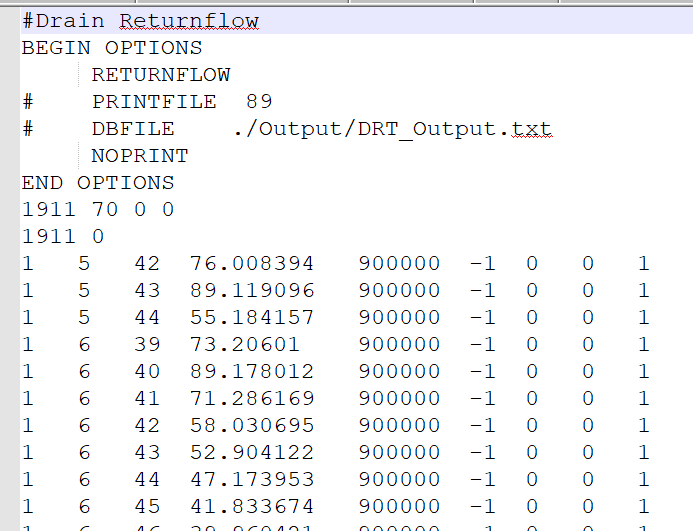

In [ ]:
head = '''#Drain Returnflow									
BEGIN OPTIONS									
     RETURNFLOW									
#    PRINTFILE  89									
#    DBFILE    ./Output/DRT_Output.txt									
     NOPRINT									
END OPTIONS									
'''

cells = np.genfromtxt(os.path.join(owhm2, 'model_arrays', 'uzf_cells.csv'), delimiter = ',', dtype = int)
vk = np.genfromtxt(os.path.join(owhm2, 'model_arrays', 'uzf_vk.uzf'), delimiter = ',', dtype = float)
run = np.genfromtxt(os.path.join(owhm2, 'model_arrays', 'uzf_route2segment.dat'), dtype = float)
farm = np.genfromtxt(os.path.join(owhm2, 'fmp_input', 'farms', 'farm2016.dat' ))
vk = np.round(vk,2)

# to add mtn front areas to drain
cells[active_sub>0] = 1


i_, j_ = np.indices(cells.shape, )+1

df = pd.DataFrame(np.hstack([cells.reshape((-1,1)), 
                             vk.reshape((-1,1)), 
                             i_.reshape((-1,1)), 
                             j_.reshape((-1,1)), 
                             ml.dis.top.array.reshape((-1,1)),
                             farm.reshape((-1,1)),
                             active_sub.reshape((-1,1))
                            ]), columns = ['ibnd', 'k', 'i', 'j', 'top', 'farm', 'subcat'])

df = df.astype({'ibnd':int, 'k':int, 'i':int, 'j':int, 'top':float, 'farm':int})

df = df.query("ibnd==1").drop(columns = 'ibnd')
df.loc[:,'k'] = 0.0033*500*500


df.loc[:,'lay'] = np.ones(df.shape[0], dtype = int)
# subcat layer is 2
c = df.loc[:,'subcat']>0
df.loc[c,'lay'] = 2
df.loc[c,'k'] = 0.0066*500*500

df.loc[:,'farm'] = df.loc[:,'farm'].astype(int)
df.loc[:,['d', ]] =-np.ones(df.shape[0], dtype = int)
df.loc[:,[ 'd2', ]] =np.zeros(df.shape[0], dtype = int)
df.loc[:,['d3']] =np.ones(df.shape[0], dtype = int)
df.loc[:,['top']] =np.round(df.loc[:,'top'])

#remove sfr locations
print(df.shape)
df = pd.merge(df, ml.sfr.df.loc[:,['i','j', 'iseg']], how = 'left')
df = df.loc[df.iseg.isnull()] # keep only cells with no iseg
print(df.shape)
df= df.drop_duplicates(['i','j'])
print(df.shape)

head2 = "{} {} 0 0\n{} {}\n".format(df.shape[0], 50,df.shape[0], 0 )

df = df.loc[:,['lay', 'i','j', 'top', 'k',  'd','farm', 'd2','d3']]
with open(os.path.join(owhm2, 'drt.drt'), 'w') as w:
    w.write(head)
    w.write(head2)
    df.to_csv(w, lineterminator = '\n', index = False, header = False, sep = '\t')
    for i in range(800):
        w.write('-1\n')

# add add K values to uzf file to be used to limit dperc

In [ ]:
ch = allprecip.loc[:,'1969-Dec':].values

ch = ch.ravel()
ch = ch[ch>0]
v = np.arange(10,99,10)
plt.scatter(v,np.percentile(ch,v))
plt.axhline(np.percentile(ch,50), ls = '--')

In [ ]:
clist = os.path.join(workspace, 'model_arrays')
files = os.listdir(clist)

files  = [x for x in files if x=='uzf_vk.uzf']
print(files)
for f in files:

    file = os.path.join(clist,f)
    # crops = np.genfromtxt(os.path.join(clist,f))
    # file = k.split()[1]
    # fl = os.path.join(workspace,file )

    if ',' in open(file, 'r').readline():
        d = ','
    else:
        d = None
        
    crops = np.genfromtxt(file, dtype= float, delimiter = d)
    crops[crops>0] = 0.0033
    fff = crops.ravel()
    
    print(pd.Series(fff[fff>0] ).median())
    # print(crops.ravel().unique())
    crops[active_sub>0] = 0.0033
    np.savetxt(os.path.join(owhm2, 'model_arrays','uzf_vk_fmp.csv'), crops,  fmt="%.4f",)

plt.imshow(crops)

# look at output

In [ ]:
hds = flopy.utils.binaryfile.HeadFile(os.path.join(owhm2,'output', 'sv_model_grid_6layers.hds'))

hd = hds.get_alldata()
# plt.figure(figsize = (10,30),dpi = 250)
fig, ax = plt.subplots(2,3, figsize = (5,10),dpi = 250)
ax = ax.ravel()

hd = np.ma.array(hd, mask = hd ==-999.)

for n in np.arange(hd[-1].shape[0]):
    ax[n].set_axis_off()
    ax[n].contourf(hd[-1,n], vmax = 1000,vmin = -200, levels=np.arange(-200, 1000, 50), cmap = 'jet',origin="upper")



In [ ]:
ml.dis.botm.array[1]

# set layer to thickness of at least 100ft for layer 2

In [ ]:
plt.imshow(active_sub)

In [ ]:
dif = ml.dis.botm.array[0] - ml.dis.botm.array[1]

c = (dif<100) & (active_sub>0)

bot = ml.dis.botm.array[1]

bot[c] = ml.dis.botm.array[0][c] - 100

np.savetxt(os.path.join(owhm2, 'model_arrays', 'bot2.txt'), bot, fmt = "%.2f")
plt.imshow(bot)

# plot layer thicknesses

In [ ]:

# plt.figure(figsize = (10,30),dpi = 250)
fig, ax = plt.subplots(2,3, figsize = (8.5,11),dpi = 250)
ax = ax.ravel()

hd = np.vstack([np.expand_dims(ml.dis.top.array, 0), ml.dis.botm.array])


for n in np.arange(6):
    ax[n].set_axis_off()
    arr = hd[n]-hd[n+1]
    if n ==1:
        arr[~((active_sub>0) | (ibnd==1))] =np.nan  
    else:
        arr[ibnd==0] =np.nan   
    contourf = ax[n].contourf(arr, vmax = 100,vmin = 0, levels=np.arange(0, 101, 10), cmap = 'jet',origin="upper", extend = 'max')
    cbar = fig.colorbar(contourf)
    ax[n].set_title(f'Layer {n+1}')

fig.suptitle('Layer thicknesses (ft)')
plt.savefig('layer_thick.png', bbox_inches = 'tight')

# make basic hydrographs

In [ ]:
modgeoms.query(f"i=={loc[0][1]} and j=={loc[0][0]}")

In [ ]:
loc = [[98, 66]]

In [ ]:
modgeoms.query(f"i=={loc[0][0]} and j=={loc[0][1]}").explore()

In [ ]:
ax = bas.plot()
subcat.exterior.plot(ax = ax)
for _,i in enumerate(loc):
    modgeoms.set_geometry(modgeoms.geometry.centroid).query(f"i=={i[1]} and j=={i[0]}").plot(ax =  ax, fc= 'k')

In [ ]:
len(loc)

# # make grid of plots

In [ ]:
os.getcwd()

In [ ]:
hds = flopy.utils.binaryfile.HeadFile(os.path.join(owhm2,'output', 'sv_model_grid_6layers.hds'))
# ii, jj = np.meshgrid(np.arange(ml.dis.ncol),np.arange(ml.nrow))

# ii = np.where(ii% 15==0, ii, np.nan)
# jj = np.where(jj% 15==0, jj, np.nan)

# ii[~((ibnd>0 ) | (active_sub>0))] = np.nan
# jj[~((ibnd>0 ) | (active_sub>0))] = np.nan

# loc = np.array(list(zip(ii.ravel(), jj.ravel())))

# c = np.isnan(loc).any(axis = 1 )

# # loc = loc[~c, :]
loc = [[35, 33]]


for v in loc:

    fig, (ax, ax1) = plt.subplots(2,1)
    active_grid_dis.exterior.plot(ax  =ax1)
    subcat.plot(ax =ax1, fc = 'None',ec = 'g')
    modgeoms.set_geometry(modgeoms.geometry.centroid).query(f"i=={v[1]} and j=={v[0]}").plot(ax =  ax1, fc= 'k')
    
    for lay in range(6):
        # n =ml.dis.get_node([lay,int(v[0]), int(v[1])])

        trans = hds.get_ts([[lay,int(v[1]), int(v[0])]])
        trans[trans[:,1]==-999,:] = np.nan
        if not np.isnan(trans[:,1]).all():
            days = pd.to_datetime('12/1/1969') + pd.to_timedelta(trans[:,0], unit = "D")
    
            ax.plot(days, trans[:,1], label = lay+1, ls = '-')

    ax.legend(title = 'Layer', bbox_to_anchor = (1,1), loc = 'upper left');
    ax.grid(True)
    ax1.set_axis_off();
    ax.set_facecolor('lightgrey')
    

# h = hds.get_alldata()

In [ ]:
from conda_scripts import arich_functions

def set_units(units = 'f'):
    if units == 'm':
        print('converting from M**3  to acre-feet')
        # convert m**3 to acre-feet, and vice-versa
        def m2ac(val):
            return (val * (3.28084 ** 3)) / 43560.

        def m2ac_area(val):
            return (val * (3.28084 ** 2)) / 43560.

        conversion = m2ac
        conversion_area = m2ac_area
    else:
        print('converting from ft per day to acre-feet')
        conversion = lambda x: x/43560.
        conversion_area = lambda x: x/43560.

    return conversion, conversion_area


def load_fb_details(fb_details, units = 'f', active_farms = None, start_date ='9/30/1959' ):

    conversion, _ = set_units(units)

    tab = pd.read_csv(fb_details, sep='\s+')

    tabd = tab.drop_duplicates(['PER', 'STP', 'DAYS']).loc[:, ['PER', 'STP', 'DAYS']]

    tabd.loc['s', :] = 0
    tabd = tabd.sort_values('PER')
    tabd.loc[:, 'dlength'] = tabd.DAYS.diff()

    tabd.loc[:, 'datetime'] = pd.to_datetime(start_date) + pd.to_timedelta(tab.DAYS, unit="D")
    tabd = tabd.drop(['s', ]).drop(columns='DAYS')
    tab = pd.merge(tab, tabd, left_on=['PER', 'STP'], right_on=['PER', 'STP'])

    tab = tab.set_index(['datetime', 'FID'])
    tab = tab.drop(
        columns=[x for x in ['PER', 'STP', 'DAYS', 'Q-Discrepancy[%]', 'DATE_START', 'ACTIVE'] if x in tab.columns])

    # convert to acre-feet
    tab = tab.multiply(tab.loc[:, 'dlength'], axis='index').applymap(conversion)


    if active_farms is None:
        print('not selecting active farms')
    else:
        print('filtering to active farms')
        # list of active farm areas
        # active = pd.Series([2, 3, 4, 10, 11, 17, 18, 19, 21, 8])
        # filter to active
        tab = tab.query("FID.isin( @active_farms )")

    # get water year
    tab_wy = tab.groupby(arich_functions.water_year(tab.index.get_level_values(0))).sum()
    tab_wy.index = pd.to_datetime(tab_wy.index, format="%Y")

    return tab_wy, tab

def load_sfr_return(return_file):

    tab = pd.read_csv(return_file, sep = '\s+')
    return  tab
fb,raw = load_fb_details(os.path.join(workspace,  "FB_DETAILS.out"))

# fb,raw = load_fb_details(os.path.join(owhm2, 'output', "FB_DETAILS.out"))
# sfr = load_sfr_return(os.path.join(owhm2, 'output', "SFR_RETURN.out"))

In [ ]:
import conda_scripts.arich_functions as af
from conda_scripts import plot_help  
#plot farms
q = raw.copy()
q = q.unstack().loc[:, q.unstack().columns[q.unstack().sum().abs() > .05]].stack()
q = q.query('FID<72').groupby(level=[0]).sum().drop(columns=['Q-tot-in', 'Q-tot-out', 'dlength'])
for c in q.columns:
    if 'out' in c:
        q.loc[:, c] = q.loc[:, c] * -1
q = q.filter(regex = 'Q')
q = q.groupby(af.water_year(q.index)).sum()
q.index = pd.to_datetime(q.index, format="%Y")
fig, ax = plot_help.stackedbar_wdates(q, colormap='tab20')

In [ ]:
sfr.query("WBS>81").groupby(['DATE_START','SEG']).sum().loc[:,['RUNOFF']].unstack()

In [ ]:
sfr.groupby(['WBS','SEG']).sum().loc[:,['RUNOFF']].unstack().droplevel(0,1).div(43265)

In [ ]:
sfr.groupby(['DATE_START','WBS','SEG']).sum().loc[:,['RUNOFF']].unstack().droplevel(0,1).div(43265)

In [ ]:
sfr.head().groupby(['WBS','SEG', 'DYEAR'])

In [ ]:
# tips = sns.load_dataset("tips")
# g = sns.FacetGrid(tips, col="time")

g = sns.FacetGrid(sfr, row="WBS", col="SEG", margin_titles=True)
g.map(sns.regplot, "DYEAR", "RUNOFF", color=".3", fit_reg=False, x_jitter=.1)

In [ ]:
import seaborn as sns
tips = sns.load_dataset("tips")
g = sns.FacetGrid(tips, col="time")

g = sns.FacetGrid(tips, row="smoker", col="time", margin_titles=True)
g.map(sns.regplot, "size", "total_bill", color=".3", fit_reg=False, x_jitter=.1)

In [ ]:
sfr.groupby(['DATE_START','WBS','SEG']).sum().loc[:,['RUNOFF']].unstack().droplevel(0,1).div(43265).plot(subplots = True,figsize = (15,15))

In [ ]:
raw.query("FID>80")

In [ ]:
raw.query("FID>80").groupby(level = [0,1]).sum().droplevel(1,0).iloc[:,cols:cols+5]

In [ ]:
q = raw.copy()

q = q.unstack().loc[:,q.unstack().columns[q.unstack().sum().abs()>.05]].stack()

q = q.query('FID<72').groupby(level = [0]).sum().drop(columns = ['Q-tot-in','Q-tot-out', 'dlength'])

for c in q.columns:
    if 'out' in c:
        q.loc[:,c] = q.loc[:,c] *-1


q = q.groupby(conda_scripts.arich_functions.water_year(q.index)).sum()
q.index = pd.to_datetime(q.index, format = "%Y")

conda_scripts.plot_help.stackedbar_wdates(q, colormap ='tab20')

In [ ]:
q = raw.copy()

q = q.unstack().loc[:,q.unstack().columns[q.unstack().sum().abs()>.05]].stack()

q = q.query('FID>80').groupby(level = [0]).sum().drop(columns = ['Q-tot-in','Q-tot-out', 'dlength'])

for c in q.columns:
    if 'out' in c:
        q.loc[:,c] = q.loc[:,c] *-1


q = q.groupby(conda_scripts.arich_functions.water_year(q.index)).sum()
q.index = pd.to_datetime(q.index, format = "%Y")

conda_scripts.plot_help.stackedbar_wdates(q, )

In [ ]:
for cols in np.arange(0, raw.shape[1],5):
    raw.query("FID>80").groupby(level = [0,1]).sum().droplevel(1,0).iloc[:,cols:cols+5].plot(subplots = True)

In [ ]:
import datetime

In [ ]:
# Create DataFrame with a datetime column
df = pd.DataFrame({'datetime_col': pd.to_datetime(['2023-01-01', '2023-01-02'])})
# Convert datetime to integer (Unix timestamp in nanoseconds)
df['timestamp_col'] = df['datetime_col'].astype('int64')
print(df)

In [ ]:
x = datetime.datetime(2000,1,1)

x.strftime("%Y-%b")

In [ ]:
og = r"C:\GSP\sv\budget\SV_mod_V2\master\fmp_input\mnw_folder\sv_fmp_deepend_1_only_GSP.mnw2"

outa = r"C:\GSP\sv\model\virtual wells update\sv_fmp_deepend_1_only_GSP_all_on_fix.mnw2"
itmp = False
cnt = 0
with open(og, 'r') as in_mnw:
        with open(outa,'w') as new:
            lin = in_mnw.readline()
            new.write(lin)
            while itmp ==False:
                
                for i in range(4):
                        lin = in_mnw.readline()
                        if 'itmp' in lin.lower():
#                             print(lin[0]+'asdfasd')
                            itmp = True
                            break
                        else:
#                             print(lin[0])
                            new.write(lin)
                        
#                 cnt = cnt+1
#                 assert cnt<2,'asdf'

print(work)
allmn = {}
for part in pd.Series(mnw).unique():
    if len(part)>1:
        print(part.split()[1])
        cur = os.path.join(work, part.split()[1])
        print(cur)
        maxq = pd.read_csv(cur, names = ['l','r','c','a','farm','maxq','name','aa'])
        maxq = funk(maxq)
        allmn[part] = maxq
        outa_link = r"C:\GSP\sv\model\virtual wells update\mnw_multi_wells_15_wells\{:}".format(os.path.basename(part.split()[1]))

        maxq.to_csv(outa_link,header = None,index = False)
    

shp_cur = []
for cnt, mna in enumerate(mnw):
    stp_cru = allmn[mna] 
    shp_cur.append(stp_cru.shape[0])

    with open(outa,'a+') as new:
        new.write(f'{stp_cru.shape[0]}      ## stress period  {cnt} ( 15 wells max from each farm)\n')
    stp_cru.loc[:,['name','aa']].to_csv(outa, mode = 'a+', index = False, header=False,sep = '\t')
    
            

                    
            


In [ ]:
lith_zones = gpd.read_file(r"T:\arich\Sonoma_Valley\hydro_stat\model_grid\ZONE\ZONATION_2\zonation_3_dissolve_lith_names.shp")

lith_zones.plot('name')

In [ ]:
def get_lay(row, col):
    ml.dis.top

In [ ]:
og = r"C:\GSP\sv\budget\SV_mod_V2\master\fmp_input\mnw_folder\sv_fmp_deepend_1_only_GSP.mnw2"

outa = r"C:\GSP\sv\model\virtual wells update\redo_layers.mnw2"
itmp = False
cnt = 0
with open(og, 'r') as in_mnw:
        with open(outa,'w') as new:
            lin = in_mnw.readline()
            new.write(lin)
            while itmp ==False:
                for i in range(4):
                        lin = in_mnw.readline()
                        if 'itmp' in lin.lower():
#                             print(lin[0]+'asdfasd')
                            itmp = True
                            break
                        else:
                            if 'LAY' in lin:
                                split = lin.split('#')[0]
#                                 print(split.strip().split(' '))
                                lay, row, col, rw= split.strip().split(' ')
                                newlays = f'{100}  {row} {col}  {rw}  ###\n'
                                new.write(newlays)
                            else:
                                new.write(lin)
                        
#                 cnt = cnt+1
#                 assert cnt<2,'asdf'
asdf
print(work)
allmn = {}
for part in pd.Series(mnw).unique():
    if len(part)>1:
        print(part.split()[1])
        cur = os.path.join(work, part.split()[1])
        print(cur)
        maxq = pd.read_csv(cur, names = ['l','r','c','a','farm','maxq','name','aa'])
        maxq = funk(maxq)
        allmn[part] = maxq
        outa_link = r"C:\GSP\sv\model\virtual wells update\mnw_multi_wells_15_wells\{:}".format(os.path.basename(part.split()[1]))

        maxq.to_csv(outa_link,header = None,index = False)
    

shp_cur = []
for cnt, mna in enumerate(mnw):
    stp_cru = allmn[mna] 
    shp_cur.append(stp_cru.shape[0])

    with open(outa,'a+') as new:
        new.write(f'{stp_cru.shape[0]}      ## stress period  {cnt} ( 15 wells max from each farm)\n')
    stp_cru.loc[:,['name','aa']].to_csv(outa, mode = 'a+', index = False, header=False,sep = '\t')
    
            

                    
            


In [ ]:
nums =  [float(t.split(' ')[0]) for t in top[:-1] if len(top)>1]
pd.DataFrame(shp_cur).join(pd.DataFrame(nums, columns =[ 'asdf'])   )

In [ ]:
{(allmn[k].shape[0], k.split()[1]) for k in allmn.keys()}

In [ ]:
allmn = {}
for part in pd.Series(mnw).unique():
    cur = os.path.join(work, mna.split()[1])
    maxq = pd.read_csv(cur, names = ['l','r','c','a','farm','maxq','name','aa'])
    maxq = funk(maxq)
    allmn[part] = maxq
allmn

In [ ]:
fff = maxq.head()
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]


In [ ]:
def funk(maxq):
    size = 15      # sample size
    replace = True  # with replacement
    fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
    return maxq.groupby('farm', as_index=True).apply(fn).drop_duplicates(['farm', 'name'])

In [ ]:
from pathlib import Path
j = r"C:\GSP\sv\budget\SV_mod_V2\master\fmp_input\mnw_folder"
aa = list()
for path in Path().rglob('*ned.link'):
    aa.append(path.name)
    
aa = set(aa)
aa = pd.Series(list(aa)).sort_values().tolist()

fig, ax = plt.subplots(2,4,figsize = (10,10),sharey= True,sharex = True)
ax = ax.ravel()
for cnt,year in enumerate(aa):

    ll = r"C:\GSP\sv\budget\SV_mod_V2\master\fmp_input\mnw_folder\{:}".format(year)
    maxq = pd.read_csv(ll, names = ['l','r','farm','a','maxq','name'])

    maxq.groupby('farm').count().loc[:,'maxq'].plot.bar(ax, ax=ax[cnt])
    ax[cnt].set_title(year.replace('_mnw_deepened.link','').replace('SV_fmp_',''))
    
    plt.figure()
    maxq = pd.read_csv(ll, names = ['l','r','c','a','farm','maxq','name','aa'])
    maxq_geo = gpd.GeoDataFrame(pd.merge(maxq,active_grid,left_on = ['r','c'], right_on = ['row','column_']),geometry = 'geometry',crs = 2226)
    axx = maxq_geo.plot('farm')
    axx.set_title(year.replace('_mnw_deepened.link','').replace('SV_fmp_',''))
    axx.text(0,0,f'num farms = {maxq_geo.shape[0]}', transform =axx.transAxes)

In [ ]:
work = r'C:\GSP\sv\budget\SV_mod_V2\master'
for mna in mnw:
    cur = os.path.join(work, mna.split()[1])
    maxq = pd.read_csv(cur, names = ['l','r','c','a','farm','maxq','name','aa'])
    asdf

In [ ]:
folder = r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master\fmp_driver"
def write_out(folder, name, var):
    outfile = os.path.join(folder, name+'_driver.txt')
    print(outfile)
    with open(outfile, 'w') as f:
        for item in var:
            f.write(item)

write_out(folder, r'crops', crops)
write_out(folder, r'mnw', mnw)
write_out(folder, r'farms', farms)
write_out(folder, r'pet', pet)
write_out(folder, r'precip', precip)
write_out(folder, r'nrd', nrd)


In [ ]:
fmp = r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master\fmp_input\mnw_folder\sv_fmp_deepend_1_only_GSP.mnw2"

name = []
thiem = []
diam =[]
info = []

with open(fmp,'r') as fm:
    for _ in range(1):
        line = fm.readline()

    while line:
        cur  =fm.readline()
        if ('FMP' in cur)| ('virt' in cur):
            pass
        else:
            break
        name.append(cur.split(' ')[0])
        thiem.append(fm.readline())
        diam.append(fm.readline())
        info.append(fm.readline())
wells = pd.DataFrame(pd.Series(info).str.split().tolist(),index = name,columns = ['lay','row','col', 'ig2', 'ig2', 'ig3','ig4','ig5'])
wells = wells.filter(regex = "^(?!ig).*")
print(wells.shape)
wells.head()

In [ ]:
wells.shape

In [ ]:
dfall = pd.DataFrame()
cnt = 1
for m in mnw:
    p = m[m.rfind('\\'):m.find('.link')]+'.link'
    try:
        cyr = pd.read_csv(os.path.join(os.path.abspath(r'C:\GSP\sv\budget\SV_mod_V2_owhm2\master\fmp_input\mnw_folder'),p.strip('\\')),
                     names = ['l','r','c', 'na','farm','qmax','fmp', 'kstp'])
        cyr.loc[:,'kstp'] = cnt
    
        dfall = dfall.append(cyr)
        cnt = cnt+1
    except:
        print(f'failed {p}')
print(dfall.shape)
dfall.head()

In [ ]:
farmlink = dfall.loc[:,['farm','fmp']].drop_duplicates()
farmlink = farmlink.sort_values('farm')
print(farmlink.shape)
farmlink.head()

In [ ]:
dfall.fmp.unique().shape

In [ ]:
wellstarts = dfall.loc[:,['fmp','kstp']].groupby('fmp').agg(['min', 'max']).droplevel(axis=1, level = 0)
wellstarts = wellstarts.rename(columns = {'min':'date_start', 'max':'date_end'})
print(wellstarts.shape)
wellstarts.head()

In [ ]:
#Name	FARM	LAYER	ROW	COL	QMAX	Date_Start	Date_End

output = pd.merge(wellstarts, farmlink, left_index = True, right_on = 'fmp')
print(output.shape)
output = pd.merge(output, wells,left_on = 'fmp',right_index= True)
print(output.shape)
output.loc[:,'QMAX']  = 1000000

output = output.loc[:,['fmp', 'farm','lay', 'row', 'col','QMAX', 'date_start', 'date_end']]
print(output.shape)
output.head()

In [ ]:
wellstarts.index[~wellstarts.index.isin(wells.index)]

In [ ]:
output.to_csv('owhm_conversion\sv_owhm_wells.in', index = False, sep='\t')

In [ ]:
divs = pd.read_csv(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\FMP_update\sv_sfr_diversion_points.in", skiprows=[0,1,2,3], sep = '\t')
print(divs.head())
sfr_link = gpd.read_file(r'C:\GSP\sv\budget\sfr_link.shp')
print(sfr_link.head())

In [ ]:
divs_link = pd.merge(divs, sfr_link.loc[:,['outreach', 'iseg', 'ireach']], left_on = ['SEG', 'RCH'], right_on = ['iseg', 'ireach'])
divs_link = divs_link.drop(columns = ['iseg', 'ireach'])
divs_link.head()

In [ ]:
sfr_return = pd.merge(divs_link, sfr_link.loc[:,['reachID', 'iseg', 'ireach']], left_on = 'outreach', right_on = 'reachID')
sfr_return.head()

In [ ]:
sfr_return_out = sfr_return.loc[:,['WBS','iseg', 'ireach']].reset_index()
sfr_return_out.loc[:,'index'] = np.arange(1,sfr_return_out.shape[0]+1)
sfr_return_out.to_csv(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\FMP_update\sv_sfr_diversion_return_points.in", index=False, header = False)

In [ ]:
divs.WBS[~divs.WBS.isin(sfr_return.WBS)]

In [ ]:
rout

In [ ]:
rout = np.genfromtxt(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\model_arrays\uzf_route2segment.dat")
farms = np.genfromtxt(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\fmp_input\farms\2012_farms.dat", delimiter = ',')
c = farms <1
rout[c] = np.nan
plt.figure()
plt.imshow(rout)

In [ ]:
farms = np.genfromtxt(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\fmp_input\farms\2012_farms.dat", delimiter = ',')
farms.shape
rout = np.genfromtxt(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\model_arrays\uzf_route2segment.dat")

xx,yy = np.indices(farms.shape)

# farms = np.hstack((np.reshape(xx,(-1,1)),np.reshape(yy,(-1,1)),np.reshape(farms,(-1,1))))

rout = np.genfromtxt(r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master\model_arrays\uzf_route2segment.dat")
rout = np.hstack((np.reshape(xx,(-1,1)),np.reshape(yy,(-1,1)),np.reshape(rout,(-1,1)), np.reshape(farms,(-1,1))))
rout = pd.DataFrame(rout, columns = ['i', 'j', 'rout', 'farm'])


rout = rout[rout.farm>0]
rout = rout.loc[:,['rout','farm']].groupby('farm').median()

rout = rout.reindex(np.arange(1,81)).fillna(0).rename(columns = {'rout':'seg'})
rout.loc[:,'isrr'] = rout.index
rout.loc[:,'rch2'] = 0
# rout.reset_index()
rout = rout.reset_index().loc[:,['isrr','farm', 'seg', 'rch2']]
rout.to_csv(r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master\FMP_update\sv_sfr_diversion_return_points.in", index=False, header = False)
rout

In [ ]:
farms = np.genfromtxt(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\fmp_input\farms\2012_farms.dat", delimiter = ',')
farms.shape
rout = np.genfromtxt(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\model_arrays\uzf_route2segment.dat")
rout.shape

In [ ]:
beg.close()

In [ ]:
v1 = r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\FMP.fmp4"
reading = list()
line = True
with open(v1, 'r') as beg:
    while line:
        line = beg.readline()
        try:
            if not(line.strip()[0]=='#'):
    #             print(line)
                reading.append(line)

        except:
            pass



In [ ]:
v1 = r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\SV_FMP_V2.fmp"
reading_upd = list()
line = True
with open(v1, 'r') as beg:
    while line:
        line = beg.readline()
        try:
            if not(line.strip()[0]=='#'):
    #             print(line)
                reading_upd.append(line)

        except:
            pass

In [ ]:
og = r"C:\GSP\sv\budget\SV_mod_V2\master\fmp_input\mnw_folder\sv_fmp_deepend_1_only_GSP.mnw2"

outa = r"C:\GSP\sv\model\virtual wells update\sv_fmp_deepend_1_only_GSP_longer.mnw2"
itmp = False
with open(og, 'r') as mnw:
    
        with open(outa,'w') as new:
            lin = mnw.readline()
            new.write(lin)
            while itmp ==False:
                
                line_nspit = mnw.readline()
                
                lin = line_nspit.split(' ')
                
                if 'fmp' in lin[0].lower():
                    pass
                else:
                    new.write(line_nspit+'    #added layer (above)\n')
                    break
                
                new.write(f'{lin[0]}  2\n')
                lin = mnw.readline()
                new.write(lin)
                lin = mnw.readline()
                new.write(lin)
                lin = mnw.readline()
                new.write(lin)
                f = lin.split()
                if f[0]=='1':
                    a = list(['       2'])
                    a.extend(lin.split()[1:])
                    rep = ' '.join(a)
                    new.write(rep+'     #added layer (below)\n')
                else:
                    a = list([f'        {int(f[0])-1}'])
                    a.extend(lin.split()[1:])
                    rep = ' '.join(a)
                    new.write(rep+'    #added layer (above)\n')
                    
            while lin:
                lin = mnw.readline()
                new.write(lin)


In [ ]:
[x for x in reading if not( x[:x.rfind('#')].strip() in [st[:st.rfind('#')].strip() for st in reading_upd]) and (not('output' in x.lower()))]

In [ ]:
[x for x in reading_upd if not( x[:x.rfind('#')].strip() in [st[:st.rfind('#')].strip() for st in reading]) and (not('output' in x))]

In [ ]:
sfr_ret__ = r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\output\SFR_RETURN.out"
sfr_return = pd.read_csv(sfr_ret__, sep =  '\s+')
sfr_return.groupby(['PER','SEG']).sum().loc[:,"RUNOFF"].plot(subplots=True)

In [ ]:
sfr_return.groupby(['PER','SEG']).sum().loc[:,"RUNOFF"].plot(subplots=True)

In [ ]:
sfr_return = sfr_return[sfr_return.SEG==19]
sfr_return = sfr_return[sfr_return.RCH==29]
sfr_return.head()

In [ ]:
farmCrop.dtypes

In [ ]:
farmCrop = pd.read_csv(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\output\ByFarm_ByCrop.txt",sep = '\s+')
farmCrop = pd.merge(farmCrop, dts, left_on = 'PER', right_on = 'kstp')
farmCrop.loc[:,'gw'] = farmCrop.filter(like = '_IRR').sum(axis=1)
farmCrop = farmCrop.loc[farmCrop.loc[:,'IRRIGATED_AREA'] >0,:]
farmCrop.loc[:,'gw']  = farmCrop.loc[:,'gw']*farmCrop.loc[:,'DELT'] /43560.

tf = farmCrop.drop(columns = 'date').groupby(['Water Year','CROP_NAME']).sum().loc[:,['gw']]
ax = ((tf.loc[:,'gw'])).unstack().mean().plot.bar()
ax.set_title('average gw pumping acre feet')
ax.grid(True)
(tf.loc[:,'gw']).unstack().tail()

In [ ]:
farmCrop = pd.read_csv(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\output\ByFarm_ByCrop.txt",sep = '\s+')
farmCrop = pd.merge(farmCrop, dts, left_on = 'PER', right_on = 'kstp')
farmCrop.loc[:,'gw'] = farmCrop.filter(like = '_IRR').sum(axis=1)
farmCrop = farmCrop.loc[farmCrop.loc[:,'IRRIGATED_AREA'] >0,:]
farmCrop.loc[:,'gw']  = farmCrop.loc[:,'gw']*farmCrop.loc[:,'DELT'] /farmCrop.loc[:,'AREA'] 

tf = farmCrop.drop(columns = 'date').groupby(['Water Year','CROP_NAME']).sum().loc[:,['gw']]
# tf = farmCrop.groupby(['Water Year','CROP_NAME']).sum().loc[:,['gw']]
ax = ((tf.loc[:,'gw'])).unstack().mean().plot.bar()
ax.set_title('average gw depth')
ax.grid(True)
(tf.loc[:,'gw']).unstack().head()

In [ ]:
farmCrop = pd.read_csv(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\output\ByFarm_ByCrop.txt",sep = '\s+')
farmCrop = pd.merge(farmCrop, dts, left_on = 'PER', right_on = 'kstp')
farmCrop.loc[:,'gw'] = farmCrop.filter(like = '_IRR').sum(axis=1)
farmCrop = farmCrop.loc[farmCrop.loc[:,'IRRIGATED_AREA'] >0,:]
farmCrop.loc[:,'gw']  = farmCrop.loc[:,'gw']*farmCrop.loc[:,'DELT']/43560

tf = farmCrop.drop(columns = 'date').groupby(['Water Year','CROP_NAME']).sum().loc[:,['gw']].unstack().sum(axis=1)

farmCrop = pd.read_csv(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master_cirnoq_off\output\ByFarm_ByCrop.txt",sep = '\s+')
farmCrop = pd.merge(farmCrop, dts, left_on = 'PER', right_on = 'kstp')
farmCrop.loc[:,'gw'] = farmCrop.filter(like = '_IRR').sum(axis=1)
farmCrop = farmCrop.loc[farmCrop.loc[:,'IRRIGATED_AREA'] >0,:]
farmCrop.loc[:,'gw']  = farmCrop.loc[:,'gw']*farmCrop.loc[:,'DELT'] /43560

tfv3 = farmCrop.drop(columns = 'date').groupby(['Water Year','CROP_NAME']).sum().loc[:,['gw']].unstack().sum(axis=1)

ax = tf.plot(c = 'b', label = 'v2 CIRNOQ on')
tfv3.plot(c = 'r', label = 'v2 CIRNOQ off',ax = ax)
ax.legend()
ax.set_title('irrigated area')

In [ ]:
import conda_scripts.plot_help as ph

In [ ]:
farmCrop = pd.read_csv(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master_cirnoq_off\output\ByFarm_ByCrop.txt",sep = '\s+')
farmCrop = pd.merge(farmCrop, dts, left_on = 'PER', right_on = 'kstp')
farmCrop.loc[:,'gw'] = farmCrop.filter(like = '_IRR').sum(axis=1)
farmCrop = farmCrop.loc[farmCrop.loc[:,'IRRIGATED_AREA'] >0,:]
farmCrop.loc[:,'gw']  = farmCrop.loc[:,'gw']*farmCrop.loc[:,'DELT'] /43560

tf = farmCrop.drop(columns = 'date').groupby(['Water Year','CROP_NAME']).sum().loc[:,['gw']]
# ax = .plot.bar(stacked = True)
fig,ax = ph.stackedbar_wdates(((tf.loc[:,'gw'])).unstack())
ax.set_title('Total gw pumping, v2 cirnoq off')
ax.grid(True)
(tf.loc[:,'gw']).unstack().head()

farmCrop = pd.read_csv(r"C:\GSP\sv\model\SV_mod_V2_owhm2\master\output\ByFarm_ByCrop.txt",sep = '\s+')
farmCrop = pd.merge(farmCrop, dts, left_on = 'PER', right_on = 'kstp')
farmCrop.loc[:,'gw'] = farmCrop.filter(like = '_IRR').sum(axis=1)
farmCrop = farmCrop.loc[farmCrop.loc[:,'IRRIGATED_AREA'] >0,:]
farmCrop.loc[:,'gw']  = farmCrop.loc[:,'gw']*farmCrop.loc[:,'DELT'] /43560

tf = farmCrop.drop(columns = 'date').groupby(['Water Year','CROP_NAME']).sum().loc[:,['gw']]
# ax = .plot.bar(stacked = True)
fig,ax = ph.stackedbar_wdates(((tf.loc[:,'gw'])).unstack())
ax.set_title('Total gw pumping, v2 cirnoq on')
ax.grid(True)
(tf.loc[:,'gw']).unstack().head()

In [ ]:
fig, (ax,ax1, ax2) = plt.subplots(1,3, sharey=True,figsize = (10,6))
fds = pd.read_csv(r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master_cirnoq_off\output\fds.out",sep = '\s+')
fds = pd.merge(fds, dts, left_on = 'PER', right_on = 'kstp')
fds = fds.groupby('Water Year').sum()*30/43560.
ax = fds.loc[:,'QREQ-FIN'].plot(marker = 'o', c = 'b', label = 'QREQ-FIN CIRNOQ = OFF',ax = ax)
fds.loc[:, 'Q-FIN'].plot(ax = ax, c= 'orange', label = 'Q-FIN CIRNOQ = OFF')
fds.loc[:, 'TFDR-FIN'].plot(ax = ax, c= 'k',ls = '-.', label = 'TFDR-FIN CIRNOQ = OFF')

fds = pd.read_csv(r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master\output\fds.out",sep = '\s+')
fds = pd.merge(fds, dts, left_on = 'PER', right_on = 'kstp')
fds = fds.groupby('Water Year').sum()*30/43560.
fds.loc[:,'QREQ-FIN'].plot(marker = 'o',c = 'g', label = 'QREQ-FIN CIRNOQ = ON',ax = ax1)
fds.loc[:, 'Q-FIN'].plot(ax = ax1, c = 'r', label = 'Q-FIN CIRNOQ = ON')
fds.loc[:, 'TFDR-FIN'].plot(ax = ax1, c= 'green',ls = '-.', label = 'TFDR-FIN CIRNOQ = ON')


ax.set_title('demanded groundwater pumping\nporton of demand satsfied with groundwater pumping')


fds = pd.read_csv(r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master_all_irrigate_on\output\fds.out",sep = '\s+')
fds = pd.merge(fds, dts, left_on = 'PER', right_on = 'kstp')
fds = fds.groupby('Water Year').sum()*30/43560.
fds.loc[:,'QREQ-FIN'].plot(marker = 'o',c = 'orange', label = 'QREQ-FIN CIRNOQ = ON  ALL IRR',ax = ax2)
fds.loc[:, 'Q-FIN'].plot(ax = ax2, c = 'brown', label = 'Q-FIN CIRNOQ = ON  ALL IRR')
fds.loc[:, 'TFDR-FIN'].plot(ax = ax2, c= 'c',ls = '-.', label = 'TFDR-FIN CIRNOQ = ON ALL IRR')
# ax
ax.legend();ax.grid(True)
ax1.legend();ax1.grid(True)
ax2.legend();ax2.grid(True)

In [ ]:
fig, (ax,ax1, ax3, ax2) = plt.subplots(1,4, sharey=True,sharex=True,figsize = (10,6))
fds = pd.read_csv(r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master_cirnoq_off_mnw_off\output\fds.out",sep = '\s+')
fds = pd.merge(fds, dts, left_on = 'PER', right_on = 'kstp')
fds = fds.groupby('Water Year').sum()*30/43560.
ax = fds.loc[:,'QREQ-FIN'].plot(marker = 'o', c = 'b', label = 'QREQ-FIN',ax = ax)
fds.loc[:, 'Q-FIN'].plot(ax = ax, c= 'orange', label = 'Q-FIN')
fds.loc[:, 'TFDR-FIN'].plot(ax = ax, c= 'k',ls = '-.', label = 'TFDR-FIN')

fds = pd.read_csv(r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master_cirnoq_off_MNW_auto_NONE\output\fds.out",sep = '\s+')
fds = pd.merge(fds, dts, left_on = 'PER', right_on = 'kstp')
fds = fds.groupby('Water Year').sum()*30/43560.
fds.loc[:,'QREQ-FIN'].plot(marker = 'o',c = 'g', label = 'QREQ-FIN',ax = ax1)
fds.loc[:, 'Q-FIN'].plot(ax = ax1, c = 'r', label = 'Q-FIN')
fds.loc[:, 'TFDR-FIN'].plot(ax = ax1, c= 'green',ls = '-.', label = 'TFDR-FIN')

fds = pd.read_csv(r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master_cirnoq_off_mnw_off_auto_all\output\fds.out",sep = '\s+')
fds = pd.merge(fds, dts, left_on = 'PER', right_on = 'kstp')
fds = fds.groupby('Water Year').sum()*30/43560.
fds.loc[:,'QREQ-FIN'].plot(marker = 'o',c = 'g', label = 'QREQ-FIN',ax = ax3)
fds.loc[:, 'Q-FIN'].plot(ax = ax3, c = 'r', label = 'Q-FIN')
fds.loc[:, 'TFDR-FIN'].plot(ax = ax3, c= 'green',ls = '-.', label = 'TFDR-FIN')



fds = pd.read_csv(r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master\output\fds.out",sep = '\s+')
fds = pd.merge(fds, dts, left_on = 'PER', right_on = 'kstp')
fds = fds.groupby('Water Year').sum()*30/43560.
fds.loc[:,'QREQ-FIN'].plot(marker = 'o',c = 'orange', label = 'QREQ-FIN',ax = ax2)
fds.loc[:, 'Q-FIN'].plot(ax = ax2, c = 'brown', label = 'Q-FIN')
fds.loc[:, 'TFDR-FIN'].plot(ax = ax2, c= 'c',ls = '-.', label = 'TFDR-FIN')
# ax
ax.legend();ax.grid(True)
ax1.legend();ax1.grid(True)
ax2.legend();ax2.grid(True)
ax3.legend();ax3.grid(True)





In [ ]:
rename = {"CU_INI":'CU-INI-initial-potential consumptve use of crop [ET*KC]',
          'CU':'CU-is the actual crop consumptive use based on water supply',
          "DEMAND_INI":'DEMAND_INI-is the irrigation demand to meet CIR_INI considering irrigation losses',
          'DEMAND':"DEMAND-irrigation demand/actual water supplied, to satisfy CIR",
          'CIR':"CIR-no irrigation losses, to meet CU_INI after anoxia/soil-stresses",
         'TRAN':"TRAN= TRAN_IRR + TRAN_PRECIP + TRAN_GW"}
fig, (ax,ax1) = plt.subplots(1,2,sharey=True,figsize = (10,4))
crops = ['VINEYARD', 'PASTURE', "FIELD_CROP"]
fluxes = ["CU_INI","CIR_INI","DEMAND_INI",'DEMAND','CIR','CU']
fluxes = ["CU_INI",'CIR','DEMAND','TRAN','EVAP_IRR', 'EVAP_PRECIP', 'EVAP_GW']
# fluxes = ['DEMAND','TRAN_IRR','EVAP_IRR']
nrows = 500000

allfarm = r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master\output\ALL_farm_details.txt"

cirnon = pd.read_csv(allfarm,sep = '\s+',nrows = nrows)
print(cirnon.columns)
cirnon = cirnon[cirnon.WBS<60]
cmax = cirnon.PER.max()
cirnon = cirnon[cirnon.PER==7]
cir = cirnon.groupby(['CROP_NAME']).sum().loc[:,fluxes]
cir.loc[crops,:].rename(columns=rename).plot.bar(ax = ax)
ax.legend(bbox_to_anchor= (0,-.5), loc = 'upper left')

plt.figure()
allfarm = r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master_cirnoq_off\output\ALL_farm_details.txt"

cirnon = pd.read_csv(allfarm,sep = '\s+',nrows = nrows)
cirnon = cirnon[cirnon.WBS<60]
cirnon = cirnon[cirnon.PER==7]
cir = cirnon.groupby(['CROP_NAME']).sum().loc[:,fluxes]
cir.loc[crops,:].plot.bar(ax = ax1,legend = False)

ax.grid(True);ax.set_title(f'NOCIRNOQ = ON\n(STRESS PERIOD < {cmax})')
ax1.grid(True);ax1.set_title(f'NOCIRNOQ = OFF\n(STRESS PERIOD < {cmax}))')

In [ ]:


rename = {"CU_INI":'CU-INI-initial-potential consumptve use of crop [ET*KC]',
          'CU':'CU-is the actual crop consumptive use based on water supply',
          "DEMAND_INI":'DEMAND_INI-is the irrigation demand to meet CIR_INI considering irrigation losses',
          'DEMAND':"DEMAND-irrigation demand/actual water supplied, to satisfy CIR",
          'CIR':"CIR-no irrigation losses, to meet CU_INI after anoxia/soil-stresses",
         'TRAN':"TRAN= TRAN_IRR + TRAN_PRECIP + TRAN_GW"}
fig, (ax,ax1) = plt.subplots(1,2,sharey=True,figsize = (10,4))
crops = ['VINEYARD', 'PASTURE', "FIELD_CROP"]
fluxes = ["CU_INI","CIR_INI","DEMAND_INI",'DEMAND','CIR','CU']
fluxes = ["CU_INI",'CIR','DEMAND','TRAN']
# fluxes = ['DEMAND','TRAN_IRR','EVAP_IRR']
nrows = 1000000000

allfarm = r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master\output\ALL_farm_details.txt"

cirnon = pd.read_csv(allfarm,sep = '\s+',nrows = nrows)

dts_tmp = dts.copy()
dts_tmp.loc[:, 'kstp'] = dts_tmp.loc[:, 'kstp']+1

cirnon = pd.merge(cirnon, dts, left_on = 'PER',right_on = 'kstp')
cirnon.groupby(['Water Year', 'CROP_NAME', "WBS"]).sum().to_excel(os.path.join('plots_temp','CU_by_WY_farm_NOCIRNOQ_ON'+'.xlsx'))
cirnon.groupby(['Water Year', 'CROP_NAME']).sum().to_excel(os.path.join('plots_temp','CU_by_WY_NOCIRNOQ_ON'+'.xlsx'))
print(cirnon.columns)
cirnon = cirnon[cirnon.WBS<69]
cirnon = cirnon[cirnon.PER==7]
cir = cirnon.groupby(['CROP_NAME']).sum().loc[:,fluxes]

cir.loc[crops,:].rename(columns=rename).plot.bar(ax = ax)
ax.legend(bbox_to_anchor= (0,-.5), loc = 'upper left')

plt.figure()
allfarm = r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master_cirnoq_off\output\ALL_farm_details.txt"

cirnon = pd.read_csv(allfarm,sep = '\s+',nrows = nrows)
dts_tmp = dts.copy()
dts_tmp.loc[:, 'kstp'] = dts_tmp.loc[:, 'kstp']+1

cirnon = pd.merge(cirnon, dts, left_on = 'PER',right_on = 'kstp')
cirnon.groupby(['Water Year', 'CROP_NAME', "WBS"]).sum().to_excel(os.path.join('plots_temp','CU_by_WY_farm_NOCIRNOQ_OFF'+'.xlsx'))
cirnon.groupby(['Water Year', 'CROP_NAME']).sum().to_excel(os.path.join('plots_temp','CU_by_WY_NOCIRNOQ_OFF'+'.xlsx'))
cirnon = cirnon[cirnon.WBS<69]
cirnon = cirnon[cirnon.PER==7]
cir = cirnon.groupby(['CROP_NAME']).sum().loc[:,fluxes]
cir.loc[crops,:].plot.bar(ax = ax1,legend = False)

ax.grid(True);ax.set_title('NOCIRNOQ = ON\n(STRESS PERIOD 7)')
ax1.grid(True);ax1.set_title('NOCIRNOQ = OFF\n(STRESS PERIOD 7)')


fig.savefig(os.path.join('plots_temp','consumptive use comparison'+'.png'), figszie = (5,5),bbox_inches = 'tight')

In [ ]:
fds = pd.read_csv(r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master\output\fds.out",sep = '\s+')
fds = pd.merge(fds, dts, left_on = 'PER', right_on = 'kstp')
farmCrop.loc[:,'gw'] = farmCrop.filter(like = '_IRR').sum(axis=1)
farmCrop = farmCrop.loc[farmCrop.loc[:,'IRRIGATED_AREA'] >0,:]
farmCrop.loc[:,'gw']  = farmCrop.loc[:,'gw']*farmCrop.loc[:,'DELT'] /43560

tf = farmCrop.groupby(['Water Year','CROP_NAME']).sum().loc[:,['gw']]
# ax = .plot.bar(stacked = True)
fig,ax = ph.stackedbar_wdates(((tf.loc[:,'gw'])).unstack())
ax.set_title('Total gw pumping, v2 CIRNOW on')
ax.grid(True)
(tf.loc[:,'gw']).unstack().head()

In [ ]:
farmCrop = pd.read_csv(r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master\output\ByFarm_ByCrop.txt",sep = '\s+')
farmCrop = pd.merge(farmCrop, dts, left_on = 'PER', right_on = 'kstp')
farmCrop.loc[:,'gw'] = farmCrop.filter(like = '_IRR').sum(axis=1)
farmCrop = farmCrop[farmCrop.loc[:,'IRRIGATED_AREA'] >0]
farmCrop.loc[:,'gw']  = farmCrop.loc[:,'gw'] /farmCrop.loc[:,'IRRIGATED_AREA'] 

tf = farmCrop.groupby(['Water Year','CROP_NAME']).sum().loc[:,['gw']]
ax = ((tf.loc[:,'gw'])).unstack().mean().plot.bar()
ax.grid(True)
(tf.loc[:,'gw']).unstack()


In [ ]:
tab = pd.read_clipboard()

In [ ]:
tab

In [ ]:
name = r'C:\GSP\sv\budget\SV_mod_V2_owhm2\master_all_irrigate_on\FMP_update\irr_all_on.txt'

for r in range(586):
    with open(name, 'a') as redo:
        redo.write('SFAC 1.0 #redo\n')
    tab.to_csv(name,sep = '\t', header = None, index = False, line_terminator = '\n',  mode='a')

In [ ]:
farmCrop = pd.read_csv(r"C:\GSP\sv\budget\SV_mod_V2_owhm2\master\output\ByFarm_ByCrop.txt",sep = '\s+')
farmCrop = pd.merge(farmCrop, dts, left_on = 'PER', right_on = 'kstp')
farmCrop.loc[:,'gw'] = farmCrop.filter(like = '_IRR').sum(axis=1)
# farmCrop.loc[:,'gw'] =( farmCrop.loc[:,'gw']/farmCrop.loc[:,'IRRIGATED_AREA'])
# farmCrop= farmCrop.set_index(farmCrop.columns[0:3].tolist())
ax = farmCrop.groupby(['Water Year','CROP_NAME']).sum().loc[:,'gw'].unstack().mean().divide(43560/30).plot.bar()
ax.legend(loc ='upper left',bbox_to_anchor = (1,1))

In [ ]:
farmCrop.groupby(['Water Year','WBS', 'CROP_NAME']).max()['IRRIGATED_AREA'].unstack().groupby('Water Year').sum().divide(43560).plot.area()

In [ ]:
ax = farmCrop.groupby(['Water Year','CROP_NAME']).mean().loc[:,'IRRIGATED_AREA'].unstack().divide(43560).plot.area()
ax.legend(bbox_to_anchor = (1,1))

In [ ]:
farmCrop = farmCrop.divide(farmCrop.loc[:,['IRRIGATED_AREA']],axis='index')

In [ ]:
farmCrop